##google drive

Mounted at /content/drive


###smooth_index

In [2]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import torch
import torch.nn.functional as F

def smooth_index_to_refractive(indexes, refractive_indices, k=10.0):
    """
    使用平滑插值將索引映射到折射率，保證梯度可微。

    indexes: 模型學習的索引（連續值），範圍 [0, len(refractive_indices)-1]
    refractive_indices: 對應的折射率列表，例如 [1.2+0.1j, 1.5+0.2j, 1.3+0.3j]
    k: 溫度參數，控制插值的平滑程度
    """
    # 確保 refractive_indices 是 PyTorch 張量，並轉為複數類型
    # refractive_indices = torch.tensor(refractive_indices, requires_grad=True, dtype=torch.complex64)

    # 計算每個索引的權重
    num_indices = len(refractive_indices)
    weights = torch.softmax(-k * (indexes.unsqueeze(-1) - torch.arange(num_indices, dtype=torch.float32)) ** 2, dim=-1)

    # 加權計算對應的折射率
    weighted_refractive = torch.sum(weights * refractive_indices, dim=-1)

    return weighted_refractive


##fab

In [5]:
from csv import DictReader
import numpy as np
wl_ag = []
n_ag = []
k_ag = []
with open('Ag.txt', 'r') as csv_file:#/content/drive/MyDrive/finaldata/March of the Three Kings 30sec.mp3
    reader = DictReader(csv_file, delimiter='\t', fieldnames=['wavelength', 'n', 'k'])
    for i, line in enumerate(reader):
        if i != 0:
            wl_ag.append(float(line['wavelength']))
            n_ag.append(float(line['n']))
            k_ag.append(float(line['k']))
wl_ag = np.array(wl_ag)
n_ag = np.array(n_ag)
k_ag = np.array(k_ag)

In [6]:

def n_al2o3(wl):#n = sqrt(1+X), wl:wavelength, ref:https://reurl.cc/g65Nqp, Sellmeier Eq
    nsq = 1 + 1.4313493*wl**2/(wl**2-0.0726631**2) + 0.65054713*wl**2/(wl**2-0.1193242**2) + 5.3414021*wl**2/(wl**2-18.028251**2)
    return torch.tensor(torch.sqrt(nsq), dtype=torch.complex128, requires_grad=True)


def n_sio2(wl):
    nsq = 1 + 0.6961663*wl**2/(wl**2-0.0684043**2) + 0.4079426*wl**2/(wl**2-0.1162414**2) + 0.8974794*wl**2/(wl**2-9.896161**2)
    return torch.tensor(torch.sqrt(nsq), dtype=torch.complex128, requires_grad=True)

def n_hfo2(wl):
    n_val = 1.875 + 6.28e-3/(wl**2) + 5.8e-4/(wl**4)
    return torch.tensor(n_val, dtype=torch.complex128, requires_grad=True)


##TMM

In [7]:
def Tr_M(nl, dl, k):
    """
    Calculates the transmission and reflection coefficients for a multi-layered structure using the transfer matrix method,
    implemented in PyTorch.

    Args:
        nl (torch.Tensor): A 1D tensor containing the refractive indices of each layer.
        dl (torch.Tensor): A 1D tensor containing the thicknesses of each layer.
        k (torch.Tensor): The wave vector of the incoming wave.

    Returns:
        tuple: A tuple containing:
            - r (torch.Tensor): The reflection coefficient.
            - t (torch.Tensor): The transmission coefficient.
    """

    nl = nl.type(torch.complex128)
    dl = dl.type(torch.complex128)
    k = k.type(torch.complex128)

    TI = torch.tensor([[(nl[0]+1)/(2*nl[0]), (nl[0]-1)/(2*nl[0])], [(nl[0]-1)/(2*nl[0]), (nl[0]+1)/(2*nl[0])]], dtype=torch.complex128)
    TD = torch.tensor([[torch.exp(1j*nl[0]*k*dl[0]),0],[0,torch.exp(-1j*nl[0]*k*dl[0])]], dtype=torch.complex128)
    TM = TD @ TI

    for i, n in enumerate(nl):
        if (i+1) < len(nl):
            n1 = n
            n2 = nl[i+1]
            d = dl[i+1]
            TI = torch.tensor([[(n2+n1)/(2*n2), (n2-n1)/(2*n2)], [(n2-n1)/(2*n2), (n2+n1)/(2*n2)]], dtype=torch.complex128)
            TD = torch.tensor([[torch.exp(1j*n2*k*d),0],[0,torch.exp(-1j*n2*k*d)]], dtype=torch.complex128)
            TM = (TD @ TI) @ TM

    n1 = nl[-1]
    n2 = 1
    TI = torch.tensor([[(n2+n1)/(2*n2), (n2-n1)/(2*n2)], [(n2-n1)/(2*n2), (n2+n1)/(2*n2)]], dtype=torch.complex128)
    TM = TI @ TM

    r = -TM[1,0]/TM[1,1]
    t = TM[0,0] - TM[0,1]*TM[1,0]/TM[1,1]

    return r, t


#CNN-1

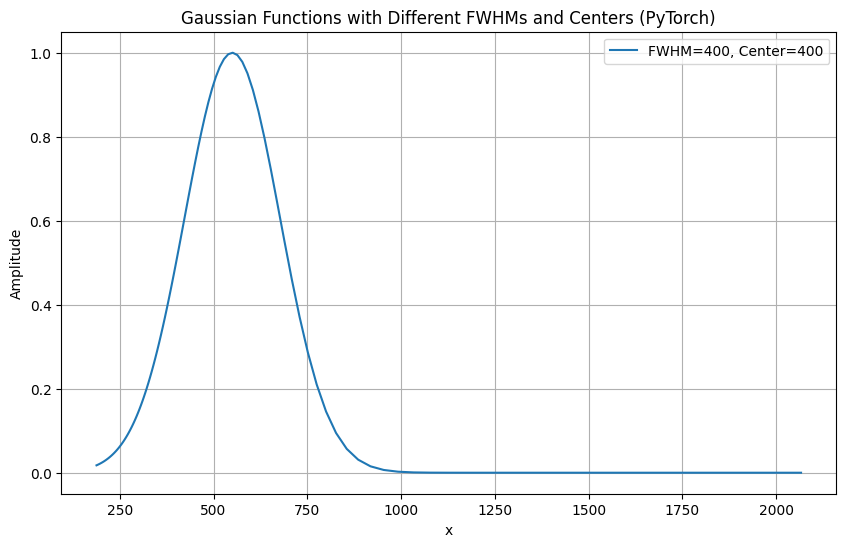

In [8]:
import torch
import matplotlib.pyplot as plt

# 定義高斯函數
def gaussian(x, mu, fwhm):
    sigma = fwhm / (2 * torch.sqrt(2 * torch.log(torch.tensor(2.0))))
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# 設定參數
x = torch.linspace(0, 2000, 1000)
fwhm_400 = 300  # 半高寬

mu_400 = 550  # 中心位置


# 計算高斯函數
gaussian_400 = gaussian(wl_ag, mu_400, fwhm_400)


# 將數據轉換為 NumPy 以供繪圖
x_np = wl_ag
gaussian_400_np = gaussian_400.numpy()


# 繪圖
plt.figure(figsize=(10, 6))
plt.plot(wl_ag, gaussian_400_np, label="FWHM=400, Center=400")

plt.title("Gaussian Functions with Different FWHMs and Centers (PyTorch)")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()



In [9]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import math


def _calculate_ti(n1, n2):
    """Calculate the transfer matrix for an interface between two media."""
    return torch.tensor([[(n2+n1)/(2*n2), (n2-n1)/(2*n2)], [(n2-n1)/(2*n2), (n2+n1)/(2*n2)]], dtype=torch.complex128)

def _calculate_td(n, k, d):
    """Calculate the transfer matrix for a layer."""
    return torch.tensor([[torch.exp(1j*n*k*d),0],[0,torch.exp(-1j*n*k*d)]], dtype=torch.complex128)


def Tr_M(nl, dl, k):
    """
    Calculates the transmission and reflection coefficients for a multi-layered structure using the transfer matrix method,
    implemented in PyTorch.

    Args:
        nl (torch.Tensor): A 1D tensor containing the refractive indices of each layer.
        dl (torch.Tensor): A 1D tensor containing the thicknesses of each layer.
        k (torch.Tensor): The wave vector of the incoming wave.

    Returns:
        tuple: A tuple containing:
            - r (torch.Tensor): The reflection coefficient.
            - t (torch.Tensor): The transmission coefficient.
    """
    nl = nl.type(torch.complex128)
    dl = dl.type(torch.complex128)
    k = k.type(torch.complex128)

    if len(nl) != len(dl):
        raise ValueError("The length of nl and dl must be the same.")

    # Initial interface (air -> layer 0)
    TI = _calculate_ti(1, nl[0])
    TD = _calculate_td(nl[0], k, dl[0])
    TM = TD @ TI

    # Layers
    for i in range(len(nl) - 1):
        TI = _calculate_ti(nl[i], nl[i+1])
        TD = _calculate_td(nl[i+1], k, dl[i+1])
        TM = (TD @ TI) @ TM

    # Last interface (layer N -> air)
    TI = _calculate_ti(nl[-1], 1)
    TM = TI @ TM

    # Calculate reflection and transmission
    epsilon = 1e-20
    r = -TM[1,0] / (TM[1,1] + epsilon)
    t = TM[0,0] - TM[0,1] * TM[1,0] / (TM[1,1] + epsilon)

    return r, t


class VTIRF_Inverse_CNN(nn.Module):
    def __init__(self, input_size, num_layers, num_materials):
        super(VTIRF_Inverse_CNN, self).__init__()
        self.num_layers = num_layers
        self.num_materials = num_materials

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.LeakyReLU(0.1) # 使用 LeakyReLU

        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.LeakyReLU(0.1) # 使用 LeakyReLU
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten = nn.Flatten()

        pooled_length = (input_size+1) //4

        self.fc1 = nn.Linear(64 * pooled_length, 128)
        self.relu3 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(128, num_layers*(1+self.num_materials))

        self._initialize_weights()

    def forward(self, x):
      x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
      x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
      x = self.flatten(x)
      x = self.relu3(self.fc1(x))
      x = self.fc2(x)
      x = torch.sigmoid(x.clone())
      scaled_x = x.clone()
      scaled_x[:, :self.num_layers] = scaled_x[:, :self.num_layers] * 20
      scaled_x[:, self.num_layers:] = scaled_x[:, self.num_layers:] * 1
      return scaled_x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)



In [12]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [18]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm



# Generate training data and save to CSV
def generate_training_data_to_csv(output_csv, num_samples, num_layers, num_materials, input_size, lambda_start, lambda_end, num_lambda_points, device):
    inputs = []
    targets = np.random.rand(num_samples, num_layers * 2)  # Random VTIRF structure parameters

    lambdas = torch.linspace(lambda_start, lambda_end, num_lambda_points)

    for i in tqdm(range(num_samples)):
        target = targets[i]

        dl = torch.tensor(target[:num_layers], dtype=torch.float32) * 20  # Thicknesses (0-200nm)
        target[:num_layers] = dl


        material_indices = torch.tensor(target[num_layers:], dtype=torch.float64)
        material_indices = material_indices * num_materials
        material_indices = material_indices.to(torch.int64)
        target[num_layers:] = material_indices
        # Generate reflection profile
        transmission = []
        for j in range(len(lambdas)):
            lam = torch.tensor(lambdas[j])
            nl = []
            for index in material_indices:
                if index == 0:
                    nl.append(n_hfo2(lam / 1e+3))  # HfO2
                elif index == 1:
                    nl.append(n_al2o3(lam / 1e+3))  # Al2O3
                elif index == 2:
                    nl.append(n_sio2(lam / 1e+3))  # SiO2
                elif index == 3:
                    nl.append(torch.complex(torch.tensor(n_ag[j]), torch.tensor(k_ag[j])))  # AgGe
            k = 2e+9 * torch.pi / lam  # Wave vector
            nl = torch.stack(nl)

            r, t = Tr_M(nl.to(device), dl.to(device) * 1e-9, torch.tensor(k).to(device))

            transmission.append(torch.abs(t).item() ** 2)

        inputs.append(transmission)

    inputs = np.array(inputs)
    data = np.hstack((inputs, targets))
    np.savetxt(output_csv, data, delimiter=",", header=','.join([f"Feature{i}" for i in range(inputs.shape[1])] + [f"Target" for i in range(32)]))

# Main script
if __name__ == '__main__':
    for _ in range(100):
        print(f"第{_}次:")
        batch_size = 32
        input_size = 121  # Number of spectral data points
        num_layers = 16
        num_materials = 4
        num_epochs = 100
        learning_rate = 0.0001

        # TMM Parameters
        lambda_start = 300  # nm
        lambda_end = 800  # nm
        num_lambda_points = input_size

        # Training data generation
        num_samples = 10000
        output_csv = f"C:/Users/User/Desktop/project/training_data{_}.csv"

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using device:", device)

        # Uncomment to generate data
        generate_training_data_to_csv(output_csv, num_samples, num_layers, num_materials, input_size, lambda_start, lambda_end, num_lambda_points, device)

        # Load training data from CSV
    


第0次:
Using device: cpu


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_24616\1901488798.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  target[:num_layers] = dl
C:\Users\User\AppData\Local\Temp\ipykernel_24616\1901488798.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  target[num_layers:] = material_indices
C:\Users\User\AppData\Local\Temp\ipykernel_24616\1901488798.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lam = torch.tensor(lambdas[j])
C:\Users\User\AppData\Local\Temp\ipykernel_24616\1529569919.py:3: UserWarning: To copy construct from a tensor, it is recom

第1次:
Using device: cpu


100%|██████████| 10000/10000 [51:18<00:00,  3.25it/s] 


第2次:
Using device: cpu


100%|██████████| 10000/10000 [50:46<00:00,  3.28it/s] 


第3次:
Using device: cpu


100%|██████████| 10000/10000 [50:31<00:00,  3.30it/s]


第4次:
Using device: cpu


100%|██████████| 10000/10000 [1:13:34<00:00,  2.27it/s]


第5次:
Using device: cpu


100%|██████████| 10000/10000 [1:09:35<00:00,  2.40it/s]


第6次:
Using device: cpu


100%|██████████| 10000/10000 [1:09:38<00:00,  2.39it/s]


第7次:
Using device: cpu


100%|██████████| 10000/10000 [58:43<00:00,  2.84it/s] 


第8次:
Using device: cpu


100%|██████████| 10000/10000 [50:16<00:00,  3.31it/s]


第9次:
Using device: cpu


100%|██████████| 10000/10000 [50:02<00:00,  3.33it/s]


第10次:
Using device: cpu


100%|██████████| 10000/10000 [50:00<00:00,  3.33it/s]


第11次:
Using device: cpu


100%|██████████| 10000/10000 [49:55<00:00,  3.34it/s]


第12次:
Using device: cpu


100%|██████████| 10000/10000 [49:52<00:00,  3.34it/s]


第13次:
Using device: cpu


100%|██████████| 10000/10000 [50:04<00:00,  3.33it/s]


第14次:
Using device: cpu


100%|██████████| 10000/10000 [49:57<00:00,  3.34it/s]


第15次:
Using device: cpu


100%|██████████| 10000/10000 [49:48<00:00,  3.35it/s]


第16次:
Using device: cpu


100%|██████████| 10000/10000 [50:01<00:00,  3.33it/s]


第17次:
Using device: cpu


100%|██████████| 10000/10000 [52:20<00:00,  3.18it/s] 


第18次:
Using device: cpu


100%|██████████| 10000/10000 [1:22:30<00:00,  2.02it/s] 


第19次:
Using device: cpu


100%|██████████| 10000/10000 [52:02<00:00,  3.20it/s]


第20次:
Using device: cpu


100%|██████████| 10000/10000 [51:50<00:00,  3.21it/s]


第21次:
Using device: cpu


100%|██████████| 10000/10000 [51:29<00:00,  3.24it/s]


第22次:
Using device: cpu


100%|██████████| 10000/10000 [51:09<00:00,  3.26it/s]


第23次:
Using device: cpu


100%|██████████| 10000/10000 [51:03<00:00,  3.26it/s]


第24次:
Using device: cpu


100%|██████████| 10000/10000 [1:19:29<00:00,  2.10it/s]


第25次:
Using device: cpu


100%|██████████| 10000/10000 [1:09:54<00:00,  2.38it/s]


第26次:
Using device: cpu


100%|██████████| 10000/10000 [57:49<00:00,  2.88it/s] 


第27次:
Using device: cpu


100%|██████████| 10000/10000 [1:10:11<00:00,  2.37it/s]


第28次:
Using device: cpu


100%|██████████| 10000/10000 [1:45:44<00:00,  1.58it/s] 


第29次:
Using device: cpu


100%|██████████| 10000/10000 [58:32<00:00,  2.85it/s] 


第30次:
Using device: cpu


100%|██████████| 10000/10000 [53:12<00:00,  3.13it/s] 


第31次:
Using device: cpu


100%|██████████| 10000/10000 [50:15<00:00,  3.32it/s]


第32次:
Using device: cpu


100%|██████████| 10000/10000 [49:56<00:00,  3.34it/s] 


第33次:
Using device: cpu


100%|██████████| 10000/10000 [49:51<00:00,  3.34it/s]


第34次:
Using device: cpu


100%|██████████| 10000/10000 [49:50<00:00,  3.34it/s]


第35次:
Using device: cpu


100%|██████████| 10000/10000 [49:43<00:00,  3.35it/s]


第36次:
Using device: cpu


100%|██████████| 10000/10000 [49:44<00:00,  3.35it/s]


第37次:
Using device: cpu


100%|██████████| 10000/10000 [49:48<00:00,  3.35it/s]


第38次:
Using device: cpu


100%|██████████| 10000/10000 [50:02<00:00,  3.33it/s]


第39次:
Using device: cpu


100%|██████████| 10000/10000 [49:42<00:00,  3.35it/s]


第40次:
Using device: cpu


100%|██████████| 10000/10000 [49:39<00:00,  3.36it/s]


第41次:
Using device: cpu


100%|██████████| 10000/10000 [49:25<00:00,  3.37it/s]


第42次:
Using device: cpu


100%|██████████| 10000/10000 [49:07<00:00,  3.39it/s]


第43次:
Using device: cpu


100%|██████████| 10000/10000 [49:31<00:00,  3.37it/s]


第44次:
Using device: cpu


100%|██████████| 10000/10000 [49:41<00:00,  3.35it/s]


第45次:
Using device: cpu


100%|██████████| 10000/10000 [49:25<00:00,  3.37it/s]


第46次:
Using device: cpu


100%|██████████| 10000/10000 [49:31<00:00,  3.36it/s]


第47次:
Using device: cpu


100%|██████████| 10000/10000 [51:02<00:00,  3.26it/s]


第48次:
Using device: cpu


100%|██████████| 10000/10000 [56:42<00:00,  2.94it/s] 


第49次:
Using device: cpu


100%|██████████| 10000/10000 [57:51<00:00,  2.88it/s] 


第50次:
Using device: cpu


100%|██████████| 10000/10000 [2:12:41<00:00,  1.26it/s] 


第51次:
Using device: cpu


100%|██████████| 10000/10000 [49:27<00:00,  3.37it/s]


第52次:
Using device: cpu


100%|██████████| 10000/10000 [49:37<00:00,  3.36it/s]


第53次:
Using device: cpu


100%|██████████| 10000/10000 [53:45<00:00,  3.10it/s]


第54次:
Using device: cpu


100%|██████████| 10000/10000 [1:06:57<00:00,  2.49it/s]


第55次:
Using device: cpu


100%|██████████| 10000/10000 [1:07:48<00:00,  2.46it/s]


第56次:
Using device: cpu


100%|██████████| 10000/10000 [1:05:24<00:00,  2.55it/s]


第57次:
Using device: cpu


100%|██████████| 10000/10000 [52:07<00:00,  3.20it/s]


第58次:
Using device: cpu


100%|██████████| 10000/10000 [51:56<00:00,  3.21it/s]


第59次:
Using device: cpu


100%|██████████| 10000/10000 [50:53<00:00,  3.28it/s]


第60次:
Using device: cpu


100%|██████████| 10000/10000 [50:28<00:00,  3.30it/s]


第61次:
Using device: cpu


100%|██████████| 10000/10000 [50:30<00:00,  3.30it/s]


第62次:
Using device: cpu


100%|██████████| 10000/10000 [50:28<00:00,  3.30it/s]


第63次:
Using device: cpu


100%|██████████| 10000/10000 [50:26<00:00,  3.30it/s]


第64次:
Using device: cpu


100%|██████████| 10000/10000 [49:55<00:00,  3.34it/s] 


第65次:
Using device: cpu


100%|██████████| 10000/10000 [49:54<00:00,  3.34it/s]


第66次:
Using device: cpu


100%|██████████| 10000/10000 [50:30<00:00,  3.30it/s]


第67次:
Using device: cpu


100%|██████████| 10000/10000 [50:30<00:00,  3.30it/s]


第68次:
Using device: cpu


100%|██████████| 10000/10000 [49:51<00:00,  3.34it/s]


第69次:
Using device: cpu


100%|██████████| 10000/10000 [1:00:21<00:00,  2.76it/s]


第70次:
Using device: cpu


100%|██████████| 10000/10000 [1:08:34<00:00,  2.43it/s]


第71次:
Using device: cpu


100%|██████████| 10000/10000 [57:59<00:00,  2.87it/s] 


第72次:
Using device: cpu


100%|██████████| 10000/10000 [1:56:54<00:00,  1.43it/s] 


第73次:
Using device: cpu


100%|██████████| 10000/10000 [1:00:14<00:00,  2.77it/s]


第74次:
Using device: cpu


100%|██████████| 10000/10000 [1:06:33<00:00,  2.50it/s]


第75次:
Using device: cpu


100%|██████████| 10000/10000 [54:05<00:00,  3.08it/s] 


第76次:
Using device: cpu


100%|██████████| 10000/10000 [50:40<00:00,  3.29it/s]


第77次:
Using device: cpu


100%|██████████| 10000/10000 [50:46<00:00,  3.28it/s]


第78次:
Using device: cpu


100%|██████████| 10000/10000 [1:03:24<00:00,  2.63it/s]


第79次:
Using device: cpu


100%|██████████| 10000/10000 [1:01:28<00:00,  2.71it/s]


第80次:
Using device: cpu


100%|██████████| 10000/10000 [55:18<00:00,  3.01it/s] 


第81次:
Using device: cpu


100%|██████████| 10000/10000 [55:00<00:00,  3.03it/s] 


第82次:
Using device: cpu


100%|██████████| 10000/10000 [50:11<00:00,  3.32it/s] 


第83次:
Using device: cpu


100%|██████████| 10000/10000 [49:54<00:00,  3.34it/s] 


第84次:
Using device: cpu


100%|██████████| 10000/10000 [49:39<00:00,  3.36it/s]


第85次:
Using device: cpu


100%|██████████| 10000/10000 [49:48<00:00,  3.35it/s]


第86次:
Using device: cpu


100%|██████████| 10000/10000 [49:43<00:00,  3.35it/s]


第87次:
Using device: cpu


100%|██████████| 10000/10000 [50:13<00:00,  3.32it/s]


第88次:
Using device: cpu


100%|██████████| 10000/10000 [50:12<00:00,  3.32it/s]


第89次:
Using device: cpu


100%|██████████| 10000/10000 [50:30<00:00,  3.30it/s]


第90次:
Using device: cpu


100%|██████████| 10000/10000 [50:41<00:00,  3.29it/s]


第91次:
Using device: cpu


100%|██████████| 10000/10000 [50:33<00:00,  3.30it/s] 


第92次:
Using device: cpu


100%|██████████| 10000/10000 [50:43<00:00,  3.29it/s]


第93次:
Using device: cpu


100%|██████████| 10000/10000 [50:21<00:00,  3.31it/s]


第94次:
Using device: cpu


100%|██████████| 10000/10000 [50:36<00:00,  3.29it/s]


第95次:
Using device: cpu


100%|██████████| 10000/10000 [50:37<00:00,  3.29it/s]


第96次:
Using device: cpu


100%|██████████| 10000/10000 [50:36<00:00,  3.29it/s]


第97次:
Using device: cpu


100%|██████████| 10000/10000 [50:30<00:00,  3.30it/s] 


第98次:
Using device: cpu


100%|██████████| 10000/10000 [50:41<00:00,  3.29it/s]


第99次:
Using device: cpu


100%|██████████| 10000/10000 [55:00<00:00,  3.03it/s] 


In [20]:
import pandas as pd
import glob
import os
from tqdm import tqdm
def merge_csv_with_pandas(folder_path, output_csv):
    """
    合併指定資料夾下的所有 CSV 檔案，並儲存成一個 CSV。

    Args:
      folder_path: 包含 CSV 檔案的資料夾路徑。
      output_csv: 合併後的 CSV 檔案路徑。
    """
    all_files = glob.glob(os.path.join(folder_path, "training_data*.csv"))
    df_list = []
    for filename in tqdm(all_files):
        df = pd.read_csv(filename)
        df_list.append(df)
    
    merged_df = pd.concat(df_list, ignore_index=True)
    merged_df.to_csv(output_csv, index=False)

if __name__ == '__main__':
    folder_path = "C:/Users/User/Desktop/project/"  # 請修改成你存放 CSV 檔案的資料夾路徑
    output_csv = "C:/Users/User/Desktop/project/merged_training_data.csv"  # 請修改成你想要儲存合併後檔案的路徑
    merge_csv_with_pandas(folder_path, output_csv)
    print(f"合併完成，檔案儲存於：{output_csv}")

100%|██████████| 101/101 [00:19<00:00,  5.08it/s]


合併完成，檔案儲存於：C:/Users/User/Desktop/project/merged_training_data.csv


In [43]:
output_csv = "C:/Users/User/Desktop/project/merged_training_data.csv"
class VTIRFDataset(Dataset):
    def __init__(self, csv_file):
        data = pd.read_csv(csv_file)
        print(data.shape)
        self.inputs = data.iloc[:, :121].values
        self.targets = data.iloc[:, 121:].values
        print(self.inputs.shape)
        print(self.targets.shape)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_data = torch.tensor(self.inputs[idx], dtype=torch.float32, requires_grad=True).unsqueeze(0)
        target_data = torch.tensor(self.targets[idx], dtype=torch.float32, requires_grad=True)
        return input_data, target_data
if __name__ == '__main__':
    output_csv = "C:/Users/User/Desktop/project/merged_training_data.csv" # Replace with your path
    batch_size = 1024
    input_size = 121  # Number of spectral data points
    num_layers = 16
    num_epochs = 200
    num_materials = 4
    learning_rate = 0.01
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    train_dataset = VTIRFDataset(output_csv)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define model
    model = VTIRF_Inverse_CNN(input_size=input_size, num_layers=num_layers, num_materials=num_materials).to(device)

    # Define loss functions
    loss_fn_ce = nn.CrossEntropyLoss()
    loss_fn_mse = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_mse = 0.0
        total_ce = 0.0
        for inputs, targets in tqdm(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)

            # Split the output into cross-entropy and MSE parts
            output_ce = outputs[:, num_layers:] #First num_layers outputs
            output_mse = outputs[:, :num_layers] #The rest output
            
            targets_ce = targets[:, num_layers:] #First num_layers targets
            targets_mse = targets[:, :num_layers] #The rest targets
            # print(output_ce)
            # print(targets_ce.size())
            targets_ce2 = []
            for i in range(len(targets_ce)):
                v = [0] * num_layers * num_materials
                for j in range(len(targets_ce[i])):
                    ele = targets_ce[i][j]
                    v[j * num_materials + int(ele.item())] = 1.
                    
                targets_ce2.append(torch.tensor(v))
                pass
            
            targets_ce2 = torch.stack(targets_ce2).to(device)
            # print(targets_ce2)
            # Compute loss using both cross entropy and MSE
            loss_ce = loss_fn_ce(output_ce, targets_ce2)
            loss_mse = loss_fn_mse(output_mse, targets_mse)
            loss = loss_ce + loss_mse  # Combine loss (you can adjust the weights)
            # print(loss_ce, loss_mse)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_ce += loss_ce.item()
            total_mse += loss_mse.item()

        avg_loss = total_loss / len(train_dataloader)
        print("total_ce:", total_ce/ len(train_dataloader), ", total_mse:", total_mse/ len(train_dataloader))
        print(f"Epoch: {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

        scheduler.step(avg_loss)

Using device: cpu
(1010000, 153)
(1010000, 121)
(1010000, 32)


100%|██████████| 987/987 [04:57<00:00,  3.32it/s]


total_ce: 66.10108738274077 , total_mse: 43.04273186000526
Epoch: 1/200, Training Loss: 109.1438


100%|██████████| 987/987 [04:36<00:00,  3.57it/s]


total_ce: 65.84681921188833 , total_mse: 31.735947262069253
Epoch: 2/200, Training Loss: 97.5828


100%|██████████| 987/987 [04:55<00:00,  3.34it/s]


total_ce: 65.77877620554018 , total_mse: 31.63113856484704
Epoch: 3/200, Training Loss: 97.4099


100%|██████████| 987/987 [04:52<00:00,  3.37it/s]


total_ce: 65.7187612856292 , total_mse: 31.563593289530868
Epoch: 4/200, Training Loss: 97.2824


100%|██████████| 987/987 [05:07<00:00,  3.21it/s]


total_ce: 65.67110205034838 , total_mse: 31.522546973030376
Epoch: 5/200, Training Loss: 97.1936


100%|██████████| 987/987 [04:22<00:00,  3.76it/s]


total_ce: 65.63001348617229 , total_mse: 31.497404127497802
Epoch: 6/200, Training Loss: 97.1274


100%|██████████| 987/987 [08:34<00:00,  1.92it/s]


total_ce: 65.60199491738548 , total_mse: 31.476343941422822
Epoch: 7/200, Training Loss: 97.0783


100%|██████████| 987/987 [07:21<00:00,  2.23it/s]


total_ce: 65.57920079873809 , total_mse: 31.462561148399036
Epoch: 8/200, Training Loss: 97.0418


100%|██████████| 987/987 [04:20<00:00,  3.79it/s]


total_ce: 65.55946664703895 , total_mse: 31.45004530252536
Epoch: 9/200, Training Loss: 97.0095


100%|██████████| 987/987 [03:55<00:00,  4.19it/s]


total_ce: 65.54391289337066 , total_mse: 31.44066525375227
Epoch: 10/200, Training Loss: 96.9846


100%|██████████| 987/987 [04:17<00:00,  3.83it/s]


total_ce: 65.53038869005569 , total_mse: 31.430740700425105
Epoch: 11/200, Training Loss: 96.9611


100%|██████████| 987/987 [04:33<00:00,  3.60it/s]


total_ce: 65.52243788698887 , total_mse: 31.42514014509794
Epoch: 12/200, Training Loss: 96.9476


100%|██████████| 987/987 [04:32<00:00,  3.62it/s]


total_ce: 65.50806543723186 , total_mse: 31.412980130861353
Epoch: 13/200, Training Loss: 96.9210


100%|██████████| 987/987 [04:35<00:00,  3.58it/s]


total_ce: 65.50026177248814 , total_mse: 31.409429950192344
Epoch: 14/200, Training Loss: 96.9097


100%|██████████| 987/987 [04:41<00:00,  3.51it/s]


total_ce: 65.49615860371846 , total_mse: 31.40475973073231
Epoch: 15/200, Training Loss: 96.9009


100%|██████████| 987/987 [04:28<00:00,  3.67it/s]


total_ce: 65.48671835268401 , total_mse: 31.401355984967047
Epoch: 16/200, Training Loss: 96.8881


100%|██████████| 987/987 [04:37<00:00,  3.56it/s]


total_ce: 65.48297062712479 , total_mse: 31.395987430483615
Epoch: 17/200, Training Loss: 96.8790


100%|██████████| 987/987 [04:36<00:00,  3.57it/s]


total_ce: 65.47682499909715 , total_mse: 31.394926851885177
Epoch: 18/200, Training Loss: 96.8718


100%|██████████| 987/987 [04:29<00:00,  3.66it/s]


total_ce: 65.47171672909938 , total_mse: 31.3930895978315
Epoch: 19/200, Training Loss: 96.8648


100%|██████████| 987/987 [04:39<00:00,  3.53it/s]


total_ce: 65.46721901937096 , total_mse: 31.38931488725069
Epoch: 20/200, Training Loss: 96.8565


100%|██████████| 987/987 [04:41<00:00,  3.51it/s]


total_ce: 65.46138152766977 , total_mse: 31.384394979042124
Epoch: 21/200, Training Loss: 96.8458


100%|██████████| 987/987 [04:37<00:00,  3.55it/s]


total_ce: 65.45871704472597 , total_mse: 31.386051309386527
Epoch: 22/200, Training Loss: 96.8448


100%|██████████| 987/987 [04:44<00:00,  3.47it/s]


total_ce: 65.45494881178712 , total_mse: 31.379643713691195
Epoch: 23/200, Training Loss: 96.8346


100%|██████████| 987/987 [04:35<00:00,  3.58it/s]


total_ce: 65.4487904835617 , total_mse: 31.376301165409725
Epoch: 24/200, Training Loss: 96.8251


100%|██████████| 987/987 [04:36<00:00,  3.57it/s]


total_ce: 65.44830558800045 , total_mse: 31.377870022465512
Epoch: 25/200, Training Loss: 96.8262


100%|██████████| 987/987 [04:36<00:00,  3.57it/s]


total_ce: 65.44626442736285 , total_mse: 31.37508587127036
Epoch: 26/200, Training Loss: 96.8214


100%|██████████| 987/987 [04:33<00:00,  3.61it/s]


total_ce: 65.4411362219968 , total_mse: 31.374804561502906
Epoch: 27/200, Training Loss: 96.8159


100%|██████████| 987/987 [04:41<00:00,  3.51it/s]


total_ce: 65.44066415804136 , total_mse: 31.37296689196802
Epoch: 28/200, Training Loss: 96.8136


100%|██████████| 987/987 [05:37<00:00,  2.92it/s]


total_ce: 65.4380610735583 , total_mse: 31.371920491907492
Epoch: 29/200, Training Loss: 96.8100


100%|██████████| 987/987 [05:39<00:00,  2.91it/s]


total_ce: 65.43170129685174 , total_mse: 31.364958371797233
Epoch: 30/200, Training Loss: 96.7967


100%|██████████| 987/987 [05:25<00:00,  3.03it/s]


total_ce: 65.43029488328743 , total_mse: 31.366732845673567
Epoch: 31/200, Training Loss: 96.7970


100%|██████████| 987/987 [05:19<00:00,  3.09it/s]


total_ce: 65.42941743334738 , total_mse: 31.367864237730263
Epoch: 32/200, Training Loss: 96.7973


100%|██████████| 987/987 [05:00<00:00,  3.28it/s]


total_ce: 65.42703417900726 , total_mse: 31.36501778367805
Epoch: 33/200, Training Loss: 96.7921


100%|██████████| 987/987 [04:30<00:00,  3.65it/s]


total_ce: 65.42489722192951 , total_mse: 31.362728047395066
Epoch: 34/200, Training Loss: 96.7876


100%|██████████| 987/987 [04:31<00:00,  3.63it/s]


total_ce: 65.42312768165101 , total_mse: 31.3658093971322
Epoch: 35/200, Training Loss: 96.7889


100%|██████████| 987/987 [04:37<00:00,  3.55it/s]


total_ce: 65.41813801124827 , total_mse: 31.359319754526126
Epoch: 36/200, Training Loss: 96.7775


100%|██████████| 987/987 [04:41<00:00,  3.51it/s]


total_ce: 65.4183162159712 , total_mse: 31.360416818172375
Epoch: 37/200, Training Loss: 96.7787


100%|██████████| 987/987 [04:32<00:00,  3.62it/s]


total_ce: 65.41676380810645 , total_mse: 31.359550188136076
Epoch: 38/200, Training Loss: 96.7763


100%|██████████| 987/987 [04:36<00:00,  3.58it/s]


total_ce: 65.41575325731087 , total_mse: 31.35957166561602
Epoch: 39/200, Training Loss: 96.7753


100%|██████████| 987/987 [04:40<00:00,  3.51it/s]


total_ce: 65.41598927382881 , total_mse: 31.35753954894154
Epoch: 40/200, Training Loss: 96.7735


100%|██████████| 987/987 [04:43<00:00,  3.48it/s]


total_ce: 65.41215345079293 , total_mse: 31.35735917598643
Epoch: 41/200, Training Loss: 96.7695


100%|██████████| 987/987 [04:30<00:00,  3.64it/s]


total_ce: 65.40953893381291 , total_mse: 31.35681927844263
Epoch: 42/200, Training Loss: 96.7664


100%|██████████| 987/987 [04:35<00:00,  3.58it/s]


total_ce: 65.41268774030661 , total_mse: 31.357165068961688
Epoch: 43/200, Training Loss: 96.7699


100%|██████████| 987/987 [04:37<00:00,  3.56it/s]


total_ce: 65.40590701736095 , total_mse: 31.351179490094246
Epoch: 44/200, Training Loss: 96.7571


100%|██████████| 987/987 [04:29<00:00,  3.67it/s]


total_ce: 65.40380622067592 , total_mse: 31.352793180471494
Epoch: 45/200, Training Loss: 96.7566


100%|██████████| 987/987 [04:31<00:00,  3.64it/s]


total_ce: 65.4067981105445 , total_mse: 31.351920886363423
Epoch: 46/200, Training Loss: 96.7587


100%|██████████| 987/987 [04:32<00:00,  3.62it/s]


total_ce: 65.4016848083929 , total_mse: 31.350505303225376
Epoch: 47/200, Training Loss: 96.7522


100%|██████████| 987/987 [04:34<00:00,  3.59it/s]


total_ce: 65.40074771467555 , total_mse: 31.349303459082453
Epoch: 48/200, Training Loss: 96.7501


100%|██████████| 987/987 [04:34<00:00,  3.60it/s]


total_ce: 65.40013953521017 , total_mse: 31.34828029505025
Epoch: 49/200, Training Loss: 96.7484


100%|██████████| 987/987 [04:50<00:00,  3.40it/s]


total_ce: 65.39987967973302 , total_mse: 31.349183328970586
Epoch: 50/200, Training Loss: 96.7491


100%|██████████| 987/987 [04:31<00:00,  3.63it/s]


total_ce: 65.39794323582055 , total_mse: 31.34609365221698
Epoch: 51/200, Training Loss: 96.7440


100%|██████████| 987/987 [04:33<00:00,  3.61it/s]


total_ce: 65.40006856715425 , total_mse: 31.349605206660588
Epoch: 52/200, Training Loss: 96.7497


100%|██████████| 987/987 [04:29<00:00,  3.67it/s]


total_ce: 65.39169125233256 , total_mse: 31.33990842786362
Epoch: 53/200, Training Loss: 96.7316


100%|██████████| 987/987 [04:38<00:00,  3.55it/s]


total_ce: 65.39310968586497 , total_mse: 31.34304359497874
Epoch: 54/200, Training Loss: 96.7362


100%|██████████| 987/987 [04:31<00:00,  3.63it/s]


total_ce: 65.39404921449547 , total_mse: 31.345443358416496
Epoch: 55/200, Training Loss: 96.7395


100%|██████████| 987/987 [04:39<00:00,  3.54it/s]


total_ce: 65.39205472689149 , total_mse: 31.342898207474143
Epoch: 56/200, Training Loss: 96.7350


100%|██████████| 987/987 [04:36<00:00,  3.56it/s]


total_ce: 65.38993438133232 , total_mse: 31.342368507578502
Epoch: 57/200, Training Loss: 96.7323


100%|██████████| 987/987 [04:43<00:00,  3.49it/s]


total_ce: 65.38954253037288 , total_mse: 31.34060105436841
Epoch: 58/200, Training Loss: 96.7301


100%|██████████| 987/987 [04:32<00:00,  3.62it/s]


total_ce: 65.39095769416477 , total_mse: 31.343338948011155
Epoch: 59/200, Training Loss: 96.7343


100%|██████████| 987/987 [04:35<00:00,  3.58it/s]


total_ce: 65.38871993168267 , total_mse: 31.342886861938354
Epoch: 60/200, Training Loss: 96.7316


100%|██████████| 987/987 [04:37<00:00,  3.56it/s]


total_ce: 65.38847364988008 , total_mse: 31.339714090874853
Epoch: 61/200, Training Loss: 96.7282


100%|██████████| 987/987 [04:35<00:00,  3.58it/s]


total_ce: 65.38503803380716 , total_mse: 31.339944825950244
Epoch: 62/200, Training Loss: 96.7250


100%|██████████| 987/987 [04:44<00:00,  3.47it/s]


total_ce: 65.38525539811742 , total_mse: 31.33950095481061
Epoch: 63/200, Training Loss: 96.7248


100%|██████████| 987/987 [04:38<00:00,  3.54it/s]


total_ce: 65.38352293035784 , total_mse: 31.338137529058177
Epoch: 64/200, Training Loss: 96.7217


100%|██████████| 987/987 [04:36<00:00,  3.57it/s]


total_ce: 65.38376707871272 , total_mse: 31.338238927731037
Epoch: 65/200, Training Loss: 96.7220


100%|██████████| 987/987 [04:36<00:00,  3.56it/s]


total_ce: 65.38096890744225 , total_mse: 31.335397386019473
Epoch: 66/200, Training Loss: 96.7164


100%|██████████| 987/987 [04:42<00:00,  3.49it/s]


total_ce: 65.38058333314781 , total_mse: 31.335373535465447
Epoch: 67/200, Training Loss: 96.7160


100%|██████████| 987/987 [04:29<00:00,  3.66it/s]


total_ce: 65.380358803236 , total_mse: 31.337005458704244
Epoch: 68/200, Training Loss: 96.7174


100%|██████████| 987/987 [04:30<00:00,  3.65it/s]


total_ce: 65.37976211810667 , total_mse: 31.33352071535986
Epoch: 69/200, Training Loss: 96.7133


100%|██████████| 987/987 [04:30<00:00,  3.65it/s]


total_ce: 65.37953219273653 , total_mse: 31.334622057496354
Epoch: 70/200, Training Loss: 96.7142


100%|██████████| 987/987 [04:26<00:00,  3.70it/s]


total_ce: 65.38062094675854 , total_mse: 31.336618659223348
Epoch: 71/200, Training Loss: 96.7172


100%|██████████| 987/987 [04:35<00:00,  3.58it/s]


total_ce: 65.37515179944256 , total_mse: 31.331419630736686
Epoch: 72/200, Training Loss: 96.7066


100%|██████████| 987/987 [04:38<00:00,  3.55it/s]


total_ce: 65.37560342558733 , total_mse: 31.33421187705182
Epoch: 73/200, Training Loss: 96.7098


100%|██████████| 987/987 [04:32<00:00,  3.62it/s]


total_ce: 65.37560167863376 , total_mse: 31.33329203063594
Epoch: 74/200, Training Loss: 96.7089


100%|██████████| 987/987 [04:39<00:00,  3.54it/s]


total_ce: 65.37554306293089 , total_mse: 31.334396439603516
Epoch: 75/200, Training Loss: 96.7099


100%|██████████| 987/987 [04:39<00:00,  3.53it/s]


total_ce: 65.37497505566752 , total_mse: 31.331188203836767
Epoch: 76/200, Training Loss: 96.7062


100%|██████████| 987/987 [04:31<00:00,  3.64it/s]


total_ce: 65.37237136825361 , total_mse: 31.33281536353516
Epoch: 77/200, Training Loss: 96.7052


100%|██████████| 987/987 [04:39<00:00,  3.53it/s]


total_ce: 65.36958050945248 , total_mse: 31.326904625395027
Epoch: 78/200, Training Loss: 96.6965


100%|██████████| 987/987 [04:29<00:00,  3.66it/s]


total_ce: 65.37102671645454 , total_mse: 31.3292531609656
Epoch: 79/200, Training Loss: 96.7003


100%|██████████| 987/987 [04:31<00:00,  3.63it/s]


total_ce: 65.36859299370825 , total_mse: 31.328031737029008
Epoch: 80/200, Training Loss: 96.6966


100%|██████████| 987/987 [04:30<00:00,  3.64it/s]


total_ce: 65.36970389384508 , total_mse: 31.33046917205161
Epoch: 81/200, Training Loss: 96.7002


100%|██████████| 987/987 [04:40<00:00,  3.52it/s]


total_ce: 65.36883500861542 , total_mse: 31.328212417246963
Epoch: 82/200, Training Loss: 96.6970


100%|██████████| 987/987 [04:32<00:00,  3.62it/s]


total_ce: 65.3674683575693 , total_mse: 31.32685619961044
Epoch: 83/200, Training Loss: 96.6943


100%|██████████| 987/987 [04:31<00:00,  3.63it/s]


total_ce: 65.36736819374525 , total_mse: 31.326461092437775
Epoch: 84/200, Training Loss: 96.6938


100%|██████████| 987/987 [04:30<00:00,  3.65it/s]


total_ce: 65.36758431354434 , total_mse: 31.32826963963842
Epoch: 85/200, Training Loss: 96.6959


100%|██████████| 987/987 [04:29<00:00,  3.66it/s]


total_ce: 65.3652820992977 , total_mse: 31.32612320958904
Epoch: 86/200, Training Loss: 96.6914


100%|██████████| 987/987 [04:30<00:00,  3.65it/s]


total_ce: 65.36906205846908 , total_mse: 31.33082795457154
Epoch: 87/200, Training Loss: 96.6999


100%|██████████| 987/987 [04:32<00:00,  3.62it/s]


total_ce: 65.36297316778274 , total_mse: 31.323234782272078
Epoch: 88/200, Training Loss: 96.6862


100%|██████████| 987/987 [04:32<00:00,  3.62it/s]


total_ce: 65.36470700373161 , total_mse: 31.328160393201834
Epoch: 89/200, Training Loss: 96.6929


100%|██████████| 987/987 [04:33<00:00,  3.61it/s]


total_ce: 65.36292156308376 , total_mse: 31.32398978313535
Epoch: 90/200, Training Loss: 96.6869


100%|██████████| 987/987 [04:34<00:00,  3.60it/s]


total_ce: 65.36223822596588 , total_mse: 31.324595751854183
Epoch: 91/200, Training Loss: 96.6868


100%|██████████| 987/987 [04:28<00:00,  3.67it/s]


total_ce: 65.36234488289165 , total_mse: 31.325797302261552
Epoch: 92/200, Training Loss: 96.6881


100%|██████████| 987/987 [04:30<00:00,  3.64it/s]


total_ce: 65.36042872219221 , total_mse: 31.32265997464413
Epoch: 93/200, Training Loss: 96.6831


100%|██████████| 987/987 [04:34<00:00,  3.59it/s]


total_ce: 65.36246240803294 , total_mse: 31.32367936842589
Epoch: 94/200, Training Loss: 96.6861


100%|██████████| 987/987 [04:37<00:00,  3.56it/s]


total_ce: 65.35890362400414 , total_mse: 31.323498164508358
Epoch: 95/200, Training Loss: 96.6824


100%|██████████| 987/987 [04:39<00:00,  3.53it/s]


total_ce: 65.36229082008988 , total_mse: 31.324801942618542
Epoch: 96/200, Training Loss: 96.6871


100%|██████████| 987/987 [04:33<00:00,  3.61it/s]


total_ce: 65.35794907621096 , total_mse: 31.320796230281378
Epoch: 97/200, Training Loss: 96.6787


100%|██████████| 987/987 [04:29<00:00,  3.66it/s]


total_ce: 65.35857266906305 , total_mse: 31.321936563880246
Epoch: 98/200, Training Loss: 96.6805


100%|██████████| 987/987 [04:32<00:00,  3.62it/s]


total_ce: 65.36021313575505 , total_mse: 31.32167158155818
Epoch: 99/200, Training Loss: 96.6819


100%|██████████| 987/987 [04:36<00:00,  3.57it/s]


total_ce: 65.28695425943764 , total_mse: 31.229469937031755
Epoch: 100/200, Training Loss: 96.5164


100%|██████████| 987/987 [04:41<00:00,  3.51it/s]


total_ce: 65.28132914627214 , total_mse: 31.221062191593127
Epoch: 101/200, Training Loss: 96.5024


100%|██████████| 987/987 [04:42<00:00,  3.49it/s]


total_ce: 65.27897003235667 , total_mse: 31.219605162754853
Epoch: 102/200, Training Loss: 96.4986


100%|██████████| 987/987 [04:34<00:00,  3.60it/s]


total_ce: 65.27707657432363 , total_mse: 31.217441160748916
Epoch: 103/200, Training Loss: 96.4945


100%|██████████| 987/987 [04:41<00:00,  3.51it/s]


total_ce: 65.27544611010025 , total_mse: 31.21759901655481
Epoch: 104/200, Training Loss: 96.4930


100%|██████████| 987/987 [04:36<00:00,  3.57it/s]


total_ce: 65.27421672631662 , total_mse: 31.21662234583645
Epoch: 105/200, Training Loss: 96.4908


100%|██████████| 987/987 [04:39<00:00,  3.53it/s]


total_ce: 65.27251344659528 , total_mse: 31.2148332045071
Epoch: 106/200, Training Loss: 96.4873


100%|██████████| 987/987 [04:50<00:00,  3.39it/s]


total_ce: 65.27079614486617 , total_mse: 31.213645204584648
Epoch: 107/200, Training Loss: 96.4844


100%|██████████| 987/987 [04:35<00:00,  3.59it/s]


total_ce: 65.270079592441 , total_mse: 31.21328289723807
Epoch: 108/200, Training Loss: 96.4834


100%|██████████| 987/987 [04:37<00:00,  3.55it/s]


total_ce: 65.2691026589066 , total_mse: 31.212805569232295
Epoch: 109/200, Training Loss: 96.4819


100%|██████████| 987/987 [04:31<00:00,  3.63it/s]


total_ce: 65.26800292072083 , total_mse: 31.210483661176223
Epoch: 110/200, Training Loss: 96.4785


100%|██████████| 987/987 [04:33<00:00,  3.61it/s]


total_ce: 65.26661614878924 , total_mse: 31.21061190573278
Epoch: 111/200, Training Loss: 96.4772


100%|██████████| 987/987 [04:33<00:00,  3.61it/s]


total_ce: 65.26611457987035 , total_mse: 31.21027766752388
Epoch: 112/200, Training Loss: 96.4764


100%|██████████| 987/987 [04:30<00:00,  3.64it/s]


total_ce: 65.26488286166206 , total_mse: 31.208586286024964
Epoch: 113/200, Training Loss: 96.4735


100%|██████████| 987/987 [04:40<00:00,  3.52it/s]


total_ce: 65.26441044213199 , total_mse: 31.208439147701863
Epoch: 114/200, Training Loss: 96.4728


100%|██████████| 987/987 [04:25<00:00,  3.72it/s]


total_ce: 65.26312019324955 , total_mse: 31.206847128051635
Epoch: 115/200, Training Loss: 96.4700


100%|██████████| 987/987 [03:58<00:00,  4.13it/s]


total_ce: 65.26255074822794 , total_mse: 31.20688892352907
Epoch: 116/200, Training Loss: 96.4694


100%|██████████| 987/987 [03:58<00:00,  4.14it/s]


total_ce: 65.26241696714268 , total_mse: 31.206812643111054
Epoch: 117/200, Training Loss: 96.4692


100%|██████████| 987/987 [03:58<00:00,  4.14it/s]


total_ce: 65.26127586635292 , total_mse: 31.20553474078425
Epoch: 118/200, Training Loss: 96.4668


100%|██████████| 987/987 [03:57<00:00,  4.16it/s]


total_ce: 65.26069315685207 , total_mse: 31.206030234015095
Epoch: 119/200, Training Loss: 96.4667


100%|██████████| 987/987 [03:58<00:00,  4.14it/s]


total_ce: 65.25986334618102 , total_mse: 31.204931417617875
Epoch: 120/200, Training Loss: 96.4648


100%|██████████| 987/987 [03:56<00:00,  4.17it/s]


total_ce: 65.25984159429022 , total_mse: 31.204476792278502
Epoch: 121/200, Training Loss: 96.4643


100%|██████████| 987/987 [07:10<00:00,  2.29it/s]


total_ce: 65.25809365903474 , total_mse: 31.204042871430772
Epoch: 122/200, Training Loss: 96.4621


100%|██████████| 987/987 [05:06<00:00,  3.22it/s]


total_ce: 65.25744418653431 , total_mse: 31.20307100290223
Epoch: 123/200, Training Loss: 96.4605


100%|██████████| 987/987 [04:46<00:00,  3.45it/s]


total_ce: 65.2569296623315 , total_mse: 31.20237765558585
Epoch: 124/200, Training Loss: 96.4593


100%|██████████| 987/987 [05:09<00:00,  3.19it/s]


total_ce: 65.25601974688281 , total_mse: 31.20262727090049
Epoch: 125/200, Training Loss: 96.4586


100%|██████████| 987/987 [05:23<00:00,  3.05it/s]


total_ce: 65.25497767362431 , total_mse: 31.200839526747497
Epoch: 126/200, Training Loss: 96.4558


100%|██████████| 987/987 [04:59<00:00,  3.30it/s]


total_ce: 65.25479801568338 , total_mse: 31.20107158363288
Epoch: 127/200, Training Loss: 96.4559


100%|██████████| 987/987 [05:09<00:00,  3.18it/s]


total_ce: 65.25467986442156 , total_mse: 31.200634613346306
Epoch: 128/200, Training Loss: 96.4553


100%|██████████| 987/987 [05:15<00:00,  3.13it/s]


total_ce: 65.2546029057063 , total_mse: 31.19993083262033
Epoch: 129/200, Training Loss: 96.4545


100%|██████████| 987/987 [05:15<00:00,  3.13it/s]


total_ce: 65.2534026867713 , total_mse: 31.19958195401301
Epoch: 130/200, Training Loss: 96.4530


100%|██████████| 987/987 [05:12<00:00,  3.16it/s]


total_ce: 65.25277088478343 , total_mse: 31.19811816539204
Epoch: 131/200, Training Loss: 96.4509


100%|██████████| 987/987 [04:15<00:00,  3.86it/s]


total_ce: 65.25217735344637 , total_mse: 31.198548062835663
Epoch: 132/200, Training Loss: 96.4507


100%|██████████| 987/987 [04:52<00:00,  3.37it/s]


total_ce: 65.25129661057616 , total_mse: 31.198197572547734
Epoch: 133/200, Training Loss: 96.4495


100%|██████████| 987/987 [05:15<00:00,  3.13it/s]


total_ce: 65.25083277121624 , total_mse: 31.197362922969923
Epoch: 134/200, Training Loss: 96.4482


100%|██████████| 987/987 [05:08<00:00,  3.20it/s]


total_ce: 65.25136944153388 , total_mse: 31.197278533904626
Epoch: 135/200, Training Loss: 96.4486


100%|██████████| 987/987 [05:07<00:00,  3.21it/s]


total_ce: 65.2495535296872 , total_mse: 31.196384485973294
Epoch: 136/200, Training Loss: 96.4459


100%|██████████| 987/987 [05:19<00:00,  3.09it/s]


total_ce: 65.24876348926425 , total_mse: 31.194931517256066
Epoch: 137/200, Training Loss: 96.4437


100%|██████████| 987/987 [05:07<00:00,  3.21it/s]


total_ce: 65.24827398669272 , total_mse: 31.195340198103295
Epoch: 138/200, Training Loss: 96.4436


100%|██████████| 987/987 [04:34<00:00,  3.59it/s]


total_ce: 65.24857967264626 , total_mse: 31.195340422269904
Epoch: 139/200, Training Loss: 96.4439


100%|██████████| 987/987 [04:46<00:00,  3.44it/s]


total_ce: 65.24791651052303 , total_mse: 31.195419359835206
Epoch: 140/200, Training Loss: 96.4433


100%|██████████| 987/987 [05:07<00:00,  3.21it/s]


total_ce: 65.24711614297637 , total_mse: 31.193949889750225
Epoch: 141/200, Training Loss: 96.4411


100%|██████████| 987/987 [05:17<00:00,  3.11it/s]


total_ce: 65.24692775026764 , total_mse: 31.193463365116138
Epoch: 142/200, Training Loss: 96.4404


100%|██████████| 987/987 [05:12<00:00,  3.16it/s]


total_ce: 65.24585395356925 , total_mse: 31.192983126809413
Epoch: 143/200, Training Loss: 96.4388


100%|██████████| 987/987 [05:02<00:00,  3.27it/s]


total_ce: 65.2465174712671 , total_mse: 31.19243393601376
Epoch: 144/200, Training Loss: 96.4390


100%|██████████| 987/987 [05:20<00:00,  3.07it/s]


total_ce: 65.24508938311081 , total_mse: 31.192463788821946
Epoch: 145/200, Training Loss: 96.4376


100%|██████████| 987/987 [05:21<00:00,  3.07it/s]


total_ce: 65.24495114961293 , total_mse: 31.192393916476945
Epoch: 146/200, Training Loss: 96.4373


100%|██████████| 987/987 [05:21<00:00,  3.07it/s]


total_ce: 65.24370047000163 , total_mse: 31.191224062454857
Epoch: 147/200, Training Loss: 96.4349


100%|██████████| 987/987 [05:24<00:00,  3.05it/s]


total_ce: 65.24425942557198 , total_mse: 31.192388169308927
Epoch: 148/200, Training Loss: 96.4366


100%|██████████| 987/987 [04:54<00:00,  3.35it/s]


total_ce: 65.24338326652241 , total_mse: 31.191044858644556
Epoch: 149/200, Training Loss: 96.4344


100%|██████████| 987/987 [05:08<00:00,  3.20it/s]


total_ce: 65.24355836383236 , total_mse: 31.190506570848893
Epoch: 150/200, Training Loss: 96.4341


100%|██████████| 987/987 [05:13<00:00,  3.15it/s]


total_ce: 65.24164752902232 , total_mse: 31.189737509328424
Epoch: 151/200, Training Loss: 96.4314


100%|██████████| 987/987 [05:07<00:00,  3.21it/s]


total_ce: 65.24215978063953 , total_mse: 31.188802881443753
Epoch: 152/200, Training Loss: 96.4310


100%|██████████| 987/987 [04:59<00:00,  3.29it/s]


total_ce: 65.24257916544225 , total_mse: 31.188994671436067
Epoch: 153/200, Training Loss: 96.4316


100%|██████████| 987/987 [05:19<00:00,  3.09it/s]


total_ce: 65.24160703216522 , total_mse: 31.18910489183791
Epoch: 154/200, Training Loss: 96.4307


100%|██████████| 987/987 [05:11<00:00,  3.17it/s]


total_ce: 65.24058320916049 , total_mse: 31.188299639005187
Epoch: 155/200, Training Loss: 96.4289


100%|██████████| 987/987 [05:14<00:00,  3.14it/s]


total_ce: 65.24115632587653 , total_mse: 31.18846889059111
Epoch: 156/200, Training Loss: 96.4296


100%|██████████| 987/987 [05:27<00:00,  3.02it/s]


total_ce: 65.24101662370089 , total_mse: 31.188068013060782
Epoch: 157/200, Training Loss: 96.4291


100%|██████████| 987/987 [05:01<00:00,  3.28it/s]


total_ce: 65.24059148013531 , total_mse: 31.18727288250986
Epoch: 158/200, Training Loss: 96.4279


100%|██████████| 987/987 [05:10<00:00,  3.17it/s]


total_ce: 65.22767534033747 , total_mse: 31.16927496109086
Epoch: 159/200, Training Loss: 96.3970


100%|██████████| 987/987 [05:22<00:00,  3.06it/s]


total_ce: 65.22732033773033 , total_mse: 31.16680585094015
Epoch: 160/200, Training Loss: 96.3941


100%|██████████| 987/987 [05:23<00:00,  3.05it/s]


total_ce: 65.22671685030394 , total_mse: 31.167027399049584
Epoch: 161/200, Training Loss: 96.3937


100%|██████████| 987/987 [05:23<00:00,  3.05it/s]


total_ce: 65.22687266928567 , total_mse: 31.167021182291172
Epoch: 162/200, Training Loss: 96.3939


100%|██████████| 987/987 [05:07<00:00,  3.21it/s]


total_ce: 65.22666214592189 , total_mse: 31.166009937738576
Epoch: 163/200, Training Loss: 96.3927


100%|██████████| 987/987 [04:42<00:00,  3.49it/s]


total_ce: 65.22683373386495 , total_mse: 31.166241598467455
Epoch: 164/200, Training Loss: 96.3931


100%|██████████| 987/987 [04:46<00:00,  3.45it/s]


total_ce: 65.22671278438548 , total_mse: 31.165918126053118
Epoch: 165/200, Training Loss: 96.3926


100%|██████████| 987/987 [04:45<00:00,  3.45it/s]


total_ce: 65.226578554967 , total_mse: 31.16526038064541
Epoch: 166/200, Training Loss: 96.3918


100%|██████████| 987/987 [04:57<00:00,  3.32it/s]


total_ce: 65.22625342062783 , total_mse: 31.16606048730852
Epoch: 167/200, Training Loss: 96.3923


100%|██████████| 987/987 [04:41<00:00,  3.51it/s]


total_ce: 65.22649157832338 , total_mse: 31.165907487801626
Epoch: 168/200, Training Loss: 96.3924


100%|██████████| 987/987 [04:40<00:00,  3.52it/s]


total_ce: 65.22589303029224 , total_mse: 31.165762339923397
Epoch: 169/200, Training Loss: 96.3917


100%|██████████| 987/987 [04:36<00:00,  3.57it/s]


total_ce: 65.22640550607606 , total_mse: 31.16577653778602
Epoch: 170/200, Training Loss: 96.3922


100%|██████████| 987/987 [04:37<00:00,  3.56it/s]


total_ce: 65.22489763006735 , total_mse: 31.162959536520543
Epoch: 171/200, Training Loss: 96.3879


100%|██████████| 987/987 [04:43<00:00,  3.48it/s]


total_ce: 65.22446722245144 , total_mse: 31.162725440878514
Epoch: 172/200, Training Loss: 96.3872


100%|██████████| 987/987 [04:44<00:00,  3.47it/s]


total_ce: 65.22465245363802 , total_mse: 31.162821699179172
Epoch: 173/200, Training Loss: 96.3875


100%|██████████| 987/987 [04:42<00:00,  3.49it/s]


total_ce: 65.22482703304581 , total_mse: 31.1625948019907
Epoch: 174/200, Training Loss: 96.3874


100%|██████████| 987/987 [04:42<00:00,  3.49it/s]


total_ce: 65.2244737464727 , total_mse: 31.162132203277
Epoch: 175/200, Training Loss: 96.3866


100%|██████████| 987/987 [04:47<00:00,  3.43it/s]


total_ce: 65.2247692521703 , total_mse: 31.16268190810987
Epoch: 176/200, Training Loss: 96.3875


100%|██████████| 987/987 [04:40<00:00,  3.52it/s]


total_ce: 65.22456982891852 , total_mse: 31.162787548556032
Epoch: 177/200, Training Loss: 96.3874


100%|██████████| 987/987 [04:40<00:00,  3.52it/s]


total_ce: 65.22446340388923 , total_mse: 31.16215913225694
Epoch: 178/200, Training Loss: 96.3866


100%|██████████| 987/987 [04:43<00:00,  3.48it/s]


total_ce: 65.22502604661379 , total_mse: 31.162674216876276
Epoch: 179/200, Training Loss: 96.3877


100%|██████████| 987/987 [04:46<00:00,  3.45it/s]


total_ce: 65.22528199850004 , total_mse: 31.162589352423176
Epoch: 180/200, Training Loss: 96.3879


100%|██████████| 987/987 [04:39<00:00,  3.53it/s]


total_ce: 65.22522221558484 , total_mse: 31.162737203827987
Epoch: 181/200, Training Loss: 96.3880


100%|██████████| 987/987 [04:39<00:00,  3.53it/s]


total_ce: 65.22502729885484 , total_mse: 31.162387399567177
Epoch: 182/200, Training Loss: 96.3874


100%|██████████| 987/987 [04:42<00:00,  3.49it/s]


total_ce: 65.22479883443259 , total_mse: 31.16276156068935
Epoch: 183/200, Training Loss: 96.3876


100%|██████████| 987/987 [04:36<00:00,  3.58it/s]


total_ce: 65.22419131200726 , total_mse: 31.162489260100546
Epoch: 184/200, Training Loss: 96.3867


100%|██████████| 987/987 [04:53<00:00,  3.36it/s]


total_ce: 65.22423690285726 , total_mse: 31.161969709541296
Epoch: 185/200, Training Loss: 96.3862


100%|██████████| 987/987 [04:39<00:00,  3.53it/s]


total_ce: 65.22483001678064 , total_mse: 31.162410023002277
Epoch: 186/200, Training Loss: 96.3872


100%|██████████| 987/987 [04:36<00:00,  3.57it/s]


total_ce: 65.2243014010011 , total_mse: 31.161959144723692
Epoch: 187/200, Training Loss: 96.3863


100%|██████████| 987/987 [04:00<00:00,  4.10it/s]


total_ce: 65.22459454908439 , total_mse: 31.162754000863767
Epoch: 188/200, Training Loss: 96.3873


100%|██████████| 987/987 [04:33<00:00,  3.61it/s]


total_ce: 65.22479663141593 , total_mse: 31.1621878236502
Epoch: 189/200, Training Loss: 96.3870


100%|██████████| 987/987 [05:10<00:00,  3.18it/s]


total_ce: 65.22436879012119 , total_mse: 31.16224421121429
Epoch: 190/200, Training Loss: 96.3866


100%|██████████| 987/987 [05:13<00:00,  3.15it/s]


total_ce: 65.22446184245287 , total_mse: 31.162107496638427
Epoch: 191/200, Training Loss: 96.3866


100%|██████████| 987/987 [04:55<00:00,  3.34it/s]


total_ce: 65.2241727293685 , total_mse: 31.162530937697266
Epoch: 192/200, Training Loss: 96.3867


100%|██████████| 987/987 [05:05<00:00,  3.23it/s]


total_ce: 65.22463920461854 , total_mse: 31.16270858200367
Epoch: 193/200, Training Loss: 96.3873


100%|██████████| 987/987 [05:01<00:00,  3.27it/s]


total_ce: 65.22459676756081 , total_mse: 31.16231168343062
Epoch: 194/200, Training Loss: 96.3869


100%|██████████| 987/987 [05:04<00:00,  3.24it/s]


total_ce: 65.22395350215645 , total_mse: 31.162068833696082
Epoch: 195/200, Training Loss: 96.3860


100%|██████████| 987/987 [04:37<00:00,  3.56it/s]


total_ce: 65.22477764682326 , total_mse: 31.162017725642087
Epoch: 196/200, Training Loss: 96.3868


100%|██████████| 987/987 [04:33<00:00,  3.61it/s]


total_ce: 65.22451653137516 , total_mse: 31.162175480959505
Epoch: 197/200, Training Loss: 96.3867


100%|██████████| 987/987 [04:59<00:00,  3.30it/s]


total_ce: 65.22455726785863 , total_mse: 31.16213480245016
Epoch: 198/200, Training Loss: 96.3867


100%|██████████| 987/987 [05:03<00:00,  3.25it/s]


total_ce: 65.22431920292168 , total_mse: 31.162484334232598
Epoch: 199/200, Training Loss: 96.3868


100%|██████████| 987/987 [05:02<00:00,  3.27it/s]

total_ce: 65.22456784233859 , total_mse: 31.161898314409342
Epoch: 200/200, Training Loss: 96.3865


In [209]:
# 轉換為 PyTorch 張量，並增加 batch_size 維度
gs = []
for i in range(len(wl_ag)):
    if 0 <= wl_ag[i] <= 900:x = 2
    else: x = 0
    gs.append(x)
# gs = gaussian_400 * .8
gs = torch.tensor(gs)

# gs = gaussian_400
I = torch.tensor(gs, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# 將張量傳遞給模型
o = model(I)[0]
o

C:\Users\User\AppData\Local\Temp\ipykernel_24616\2836785776.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I = torch.tensor(gs, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)


tensor([9.4393e+00, 9.5711e+00, 7.3473e+00, 3.3884e+00, 6.4285e+00, 9.2341e+00,
        5.1569e+00, 9.7248e+00, 1.0205e+01, 6.3629e+00, 2.3051e+00, 8.1361e+00,
        8.5258e+00, 8.2070e+00, 1.2276e+01, 9.4719e+00, 6.9996e-03, 9.8942e-01,
        9.9902e-01, 1.0000e+00, 9.8900e-01, 9.7472e-01, 3.0618e-14, 1.0000e+00,
        1.0000e+00, 9.9766e-01, 8.8620e-20, 9.9936e-01, 1.0000e+00, 9.9999e-01,
        1.0974e-13, 5.8824e-09, 1.0000e+00, 9.9998e-01, 2.8359e-08, 4.8435e-07,
        1.0000e+00, 1.0000e+00, 5.7400e-02, 1.0171e-12, 9.5157e-01, 9.9861e-01,
        1.0000e+00, 1.5445e-17, 3.1882e-02, 9.9980e-01, 1.0000e+00, 6.5903e-30,
        1.6435e-01, 9.9975e-01, 1.0000e+00, 8.3173e-31, 9.9992e-01, 9.9993e-01,
        1.0000e+00, 4.9767e-21, 1.0000e+00, 1.0000e+00, 3.5977e-01, 7.0629e-14,
        1.0000e+00, 1.0000e+00, 1.5247e-08, 1.6260e-09, 1.0000e+00, 1.0000e+00,
        6.0465e-15, 2.0499e-08, 1.0000e+00, 9.8357e-01, 6.0676e-17, 9.9560e-01,
        9.9978e-01, 8.0983e-01, 9.9544e-

In [210]:
materialx = o[16:]
distance = o[:16]

##厚度序列

In [211]:
distance

tensor([ 9.4393,  9.5711,  7.3473,  3.3884,  6.4285,  9.2341,  5.1569,  9.7248,
        10.2054,  6.3629,  2.3051,  8.1361,  8.5258,  8.2070, 12.2760,  9.4719],
       grad_fn=<SliceBackward0>)

##材料序列

In [212]:
material = []
for i in range(16):
    v = materialx[i * 4:(i + 1) * 4]
    M_index = 0
    M = 0
    for j in range(len(v)):
        if v[j] > M:
            M = v[j]
            M_index = j
    material.append(M_index)
material

[3, 3, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 3, 3]

##頻譜序列(最後一行output)

In [226]:
transmission = []


for i in range(len(wl_ag)):
    lam = wl_ag[i]
    lam = torch.tensor(lam)
    nl = []
    M_seq = []
    Th_seq = []
    Th_seq_index = -1
    last = -1
    for (index, d) in zip(material, distance):

        if index == 0 :
            nl.append(n_hfo2(lam / 1000)) # HfO2
            if last != index:
                M_seq.append("Hfo2")
                last = index
                Th_seq.append(d.item())
                Th_seq_index += 1
            else:
                Th_seq[Th_seq_index] += d.item()

        elif index == 1:
            nl.append(n_al2o3(lam / 1000))  # Al2O3
            if last != index:
                M_seq.append("Al2O3")
                last = index
                Th_seq.append(d.item())
                Th_seq_index += 1
            else:
                Th_seq[Th_seq_index] += d.item()
        elif index == 2:
            nl.append(n_sio2(lam / 1000))  # SiO2
            if last != index:
                M_seq.append("SiO2")
                last = index
                Th_seq.append(d.item())
                Th_seq_index += 1
            else:
                Th_seq[Th_seq_index] += d.item()
        elif index == 3:
            nl.append(torch.complex(
                torch.tensor(n_ag[i]),
                torch.tensor(k_ag[i]),
            )) # AgGe
            if last != index:
                M_seq.append("Ag")
                last = index
                Th_seq.append(d.item())
                Th_seq_index += 1
            else:
                Th_seq[Th_seq_index] += d.item()
    
    
    k = 2e+9 * torch.pi / lam #波數
    nl = torch.stack(nl)



    r, t = Tr_M(nl.to(device), distance.to(device) / 1e9, torch.tensor(k).to(device))

    transmission.append(torch.abs(t).item() ** 2)
print(transmission)
print("材料序列:", M_seq)
print("厚度序列:", Th_seq)

C:\Users\User\AppData\Local\Temp\ipykernel_24616\1529569919.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(n_val, dtype=torch.complex128, requires_grad=True)
C:\Users\User\AppData\Local\Temp\ipykernel_24616\1529569919.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sqrt(nsq), dtype=torch.complex128, requires_grad=True)
C:\Users\User\AppData\Local\Temp\ipykernel_24616\3881271620.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r, t = Tr_M(nl.to(device), distance.to(device) / 1e9, 

[0.02697932909657119, 0.025838821175529925, 0.02558285297322033, 0.025705584444149044, 0.025772956274107146, 0.025881949094307237, 0.026110879289955164, 0.026533143964832084, 0.027233447535795416, 0.028337639262255517, 0.029817319424177247, 0.03173969521918102, 0.03400669884489362, 0.03649405254927349, 0.039282768562892256, 0.04233474327428647, 0.045692673678260354, 0.04950320356118835, 0.053623001208768256, 0.057944050849378516, 0.06241148282223404, 0.06696663838119228, 0.0715402880852321, 0.07604420437338653, 0.08030726089991651, 0.08413488555723161, 0.08750958704144987, 0.09043227740243798, 0.09283105517630008, 0.09470273804754328, 0.09607852583554842, 0.09701491387279738, 0.09771489637800576, 0.09847479471995972, 0.09913978320049069, 0.09962258204007378, 0.09996614992978686, 0.09991779162815284, 0.10021886362261379, 0.10177474944262993, 0.10381979949304856, 0.10534475902413586, 0.10765761534307533, 0.11194532363129572, 0.11773259524351354, 0.12463484890260446, 0.13356391016644698, 

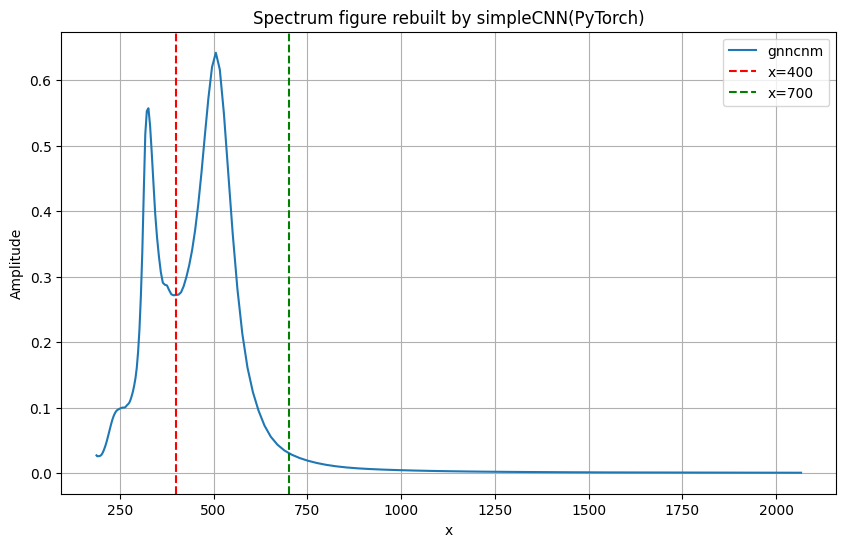

In [229]:
# 繪圖
plt.figure(figsize=(10, 6))
plt.plot(wl_ag, transmission, label="gnncnm")
# 加上 x=400 和 x=700 的垂直線
plt.axvline(x=400, color='r', linestyle='--', label='x=400')
plt.axvline(x=700, color='g', linestyle='--', label='x=700')
plt.title("Spectrum figure rebuilt by simpleCNN(PyTorch)")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [228]:
a = 0
b = 0
for i in range(len(wl_ag)):
    wl = wl_ag[i]
    if wl > 400:
        if wl < 700:
            a += transmission[i]
        b += transmission[i]

print("fom: ", a / b)

fom:  0.981284561474779


#CNN-2